In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = '/home/silvia/Documentos/Carcinosarcomas/pyscenic/pyscenic_E1'
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "E1_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "E1_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "E1_anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "E1_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'E1_scenic_integrated-output.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.7.2
sinfo       0.3.4
-----
MulticoreTSNE       NA
PIL                 8.4.0
backcall            0.2.0
cffi                1.14.6
cloudpickle         2.2.1
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.0
dateutil            2.8.2
decorator           4.4.2
defusedxml          0.7.1
entrypoints         0.4
get_version         2.1
h5py                2.10.0
igraph              0.9.6
immutables          0.19
ipykernel 

In [4]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

In [7]:
exprMat = pd.read_csv("~/Documentos/Carcinosarcomas/E1_exprMat.csv", index_col=0)
adata = exprMat.T
adata = sc.AnnData(adata) 
print(adata)

AnnData object with n_obs × n_vars = 16931 × 18082


In [8]:
row_attrs = { 
    "Gene": np.array(adata.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(adata.obs.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create(f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [11]:
import anndata as ad

adata = ad.read_loom("E1_unfiltered.loom")

# Convertir índices a str
adata.var.index = adata.var.index.astype(str)
adata.obs.index = adata.obs.index.astype(str)

# Guardar el archivo nuevamente
adata.write_loom("E1_unfiltered_fixed.loom")


In [12]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  662969.0
Number of cells in which each gene is detected: 0  -  16624


In [13]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  507.93
minSamples:  169.31


In [14]:
import scipy.sparse as sp

adata.X = sp.csr_matrix(adata.X)  # Convierte a matriz dispersa

In [15]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

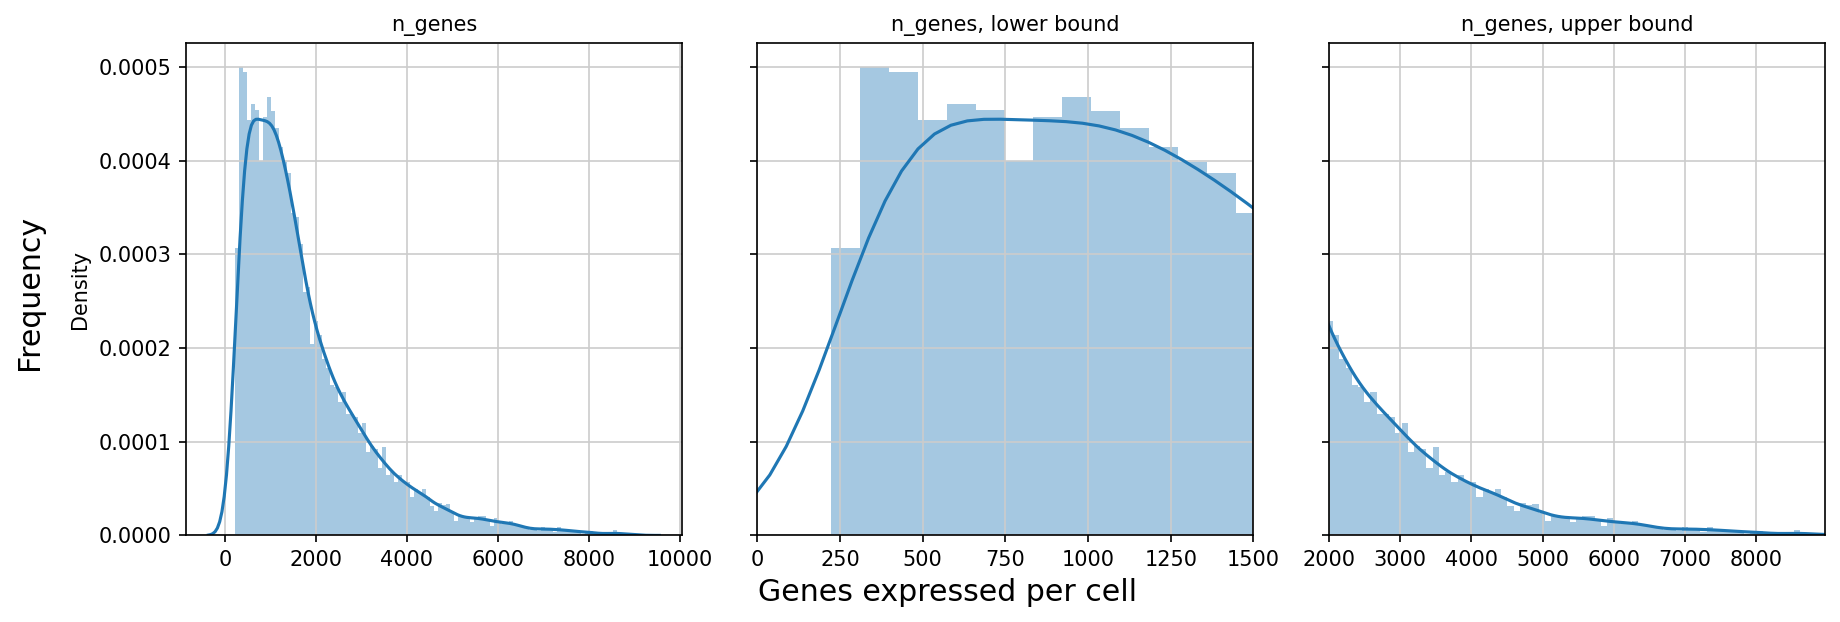

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

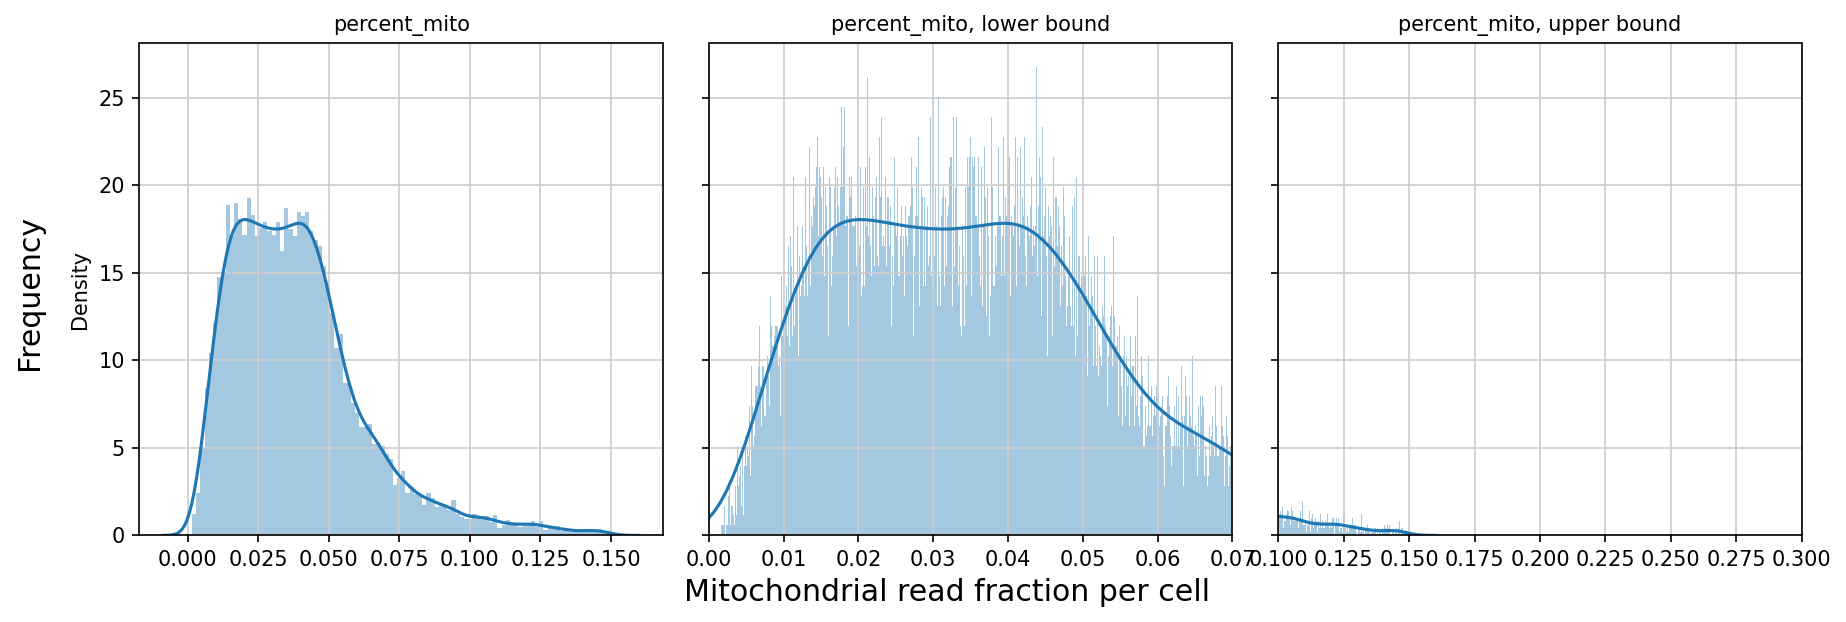

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

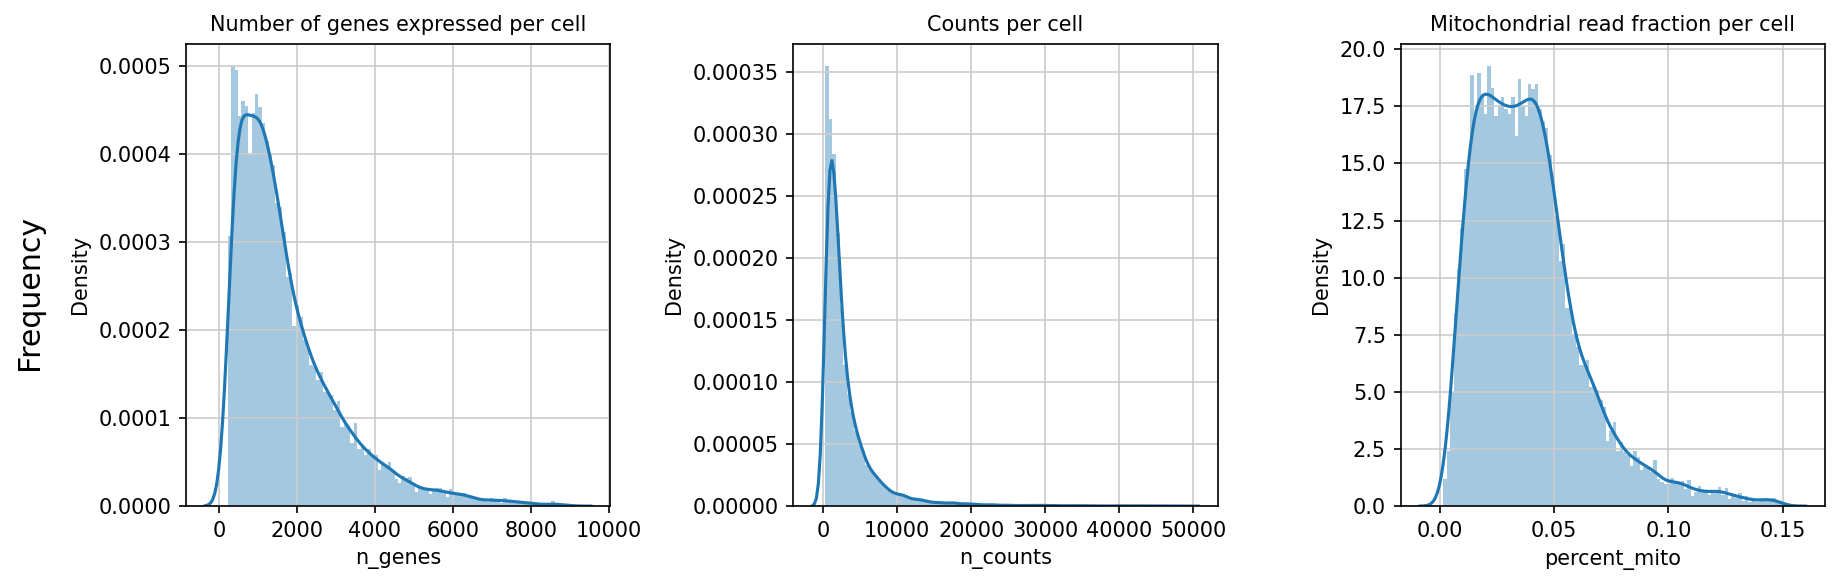

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

In [19]:
print(adata.obs['n_genes'].min(), adata.obs['n_genes'].max())

223 8963


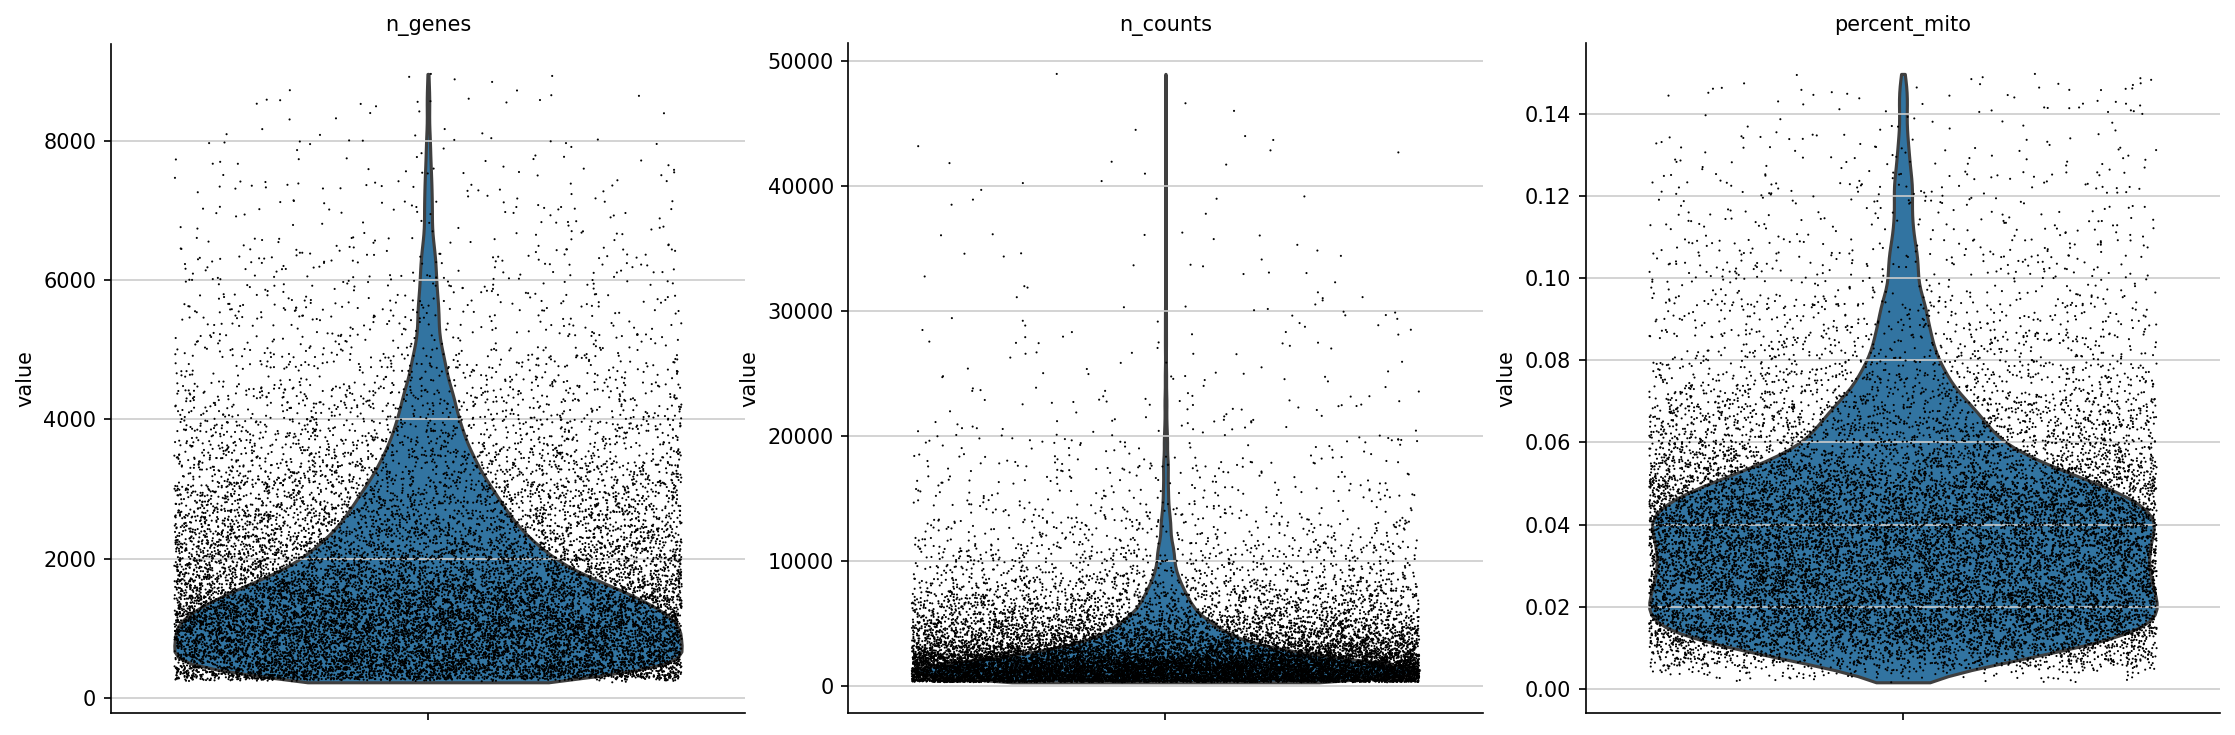

In [20]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

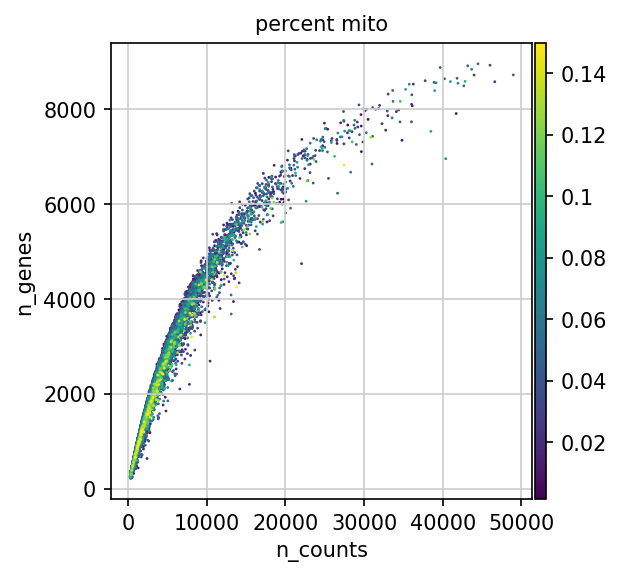

In [21]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [22]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 1599 genes that are detected in less than 3 cells


In [23]:
adata = adata[adata.obs['n_genes'] < 8000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

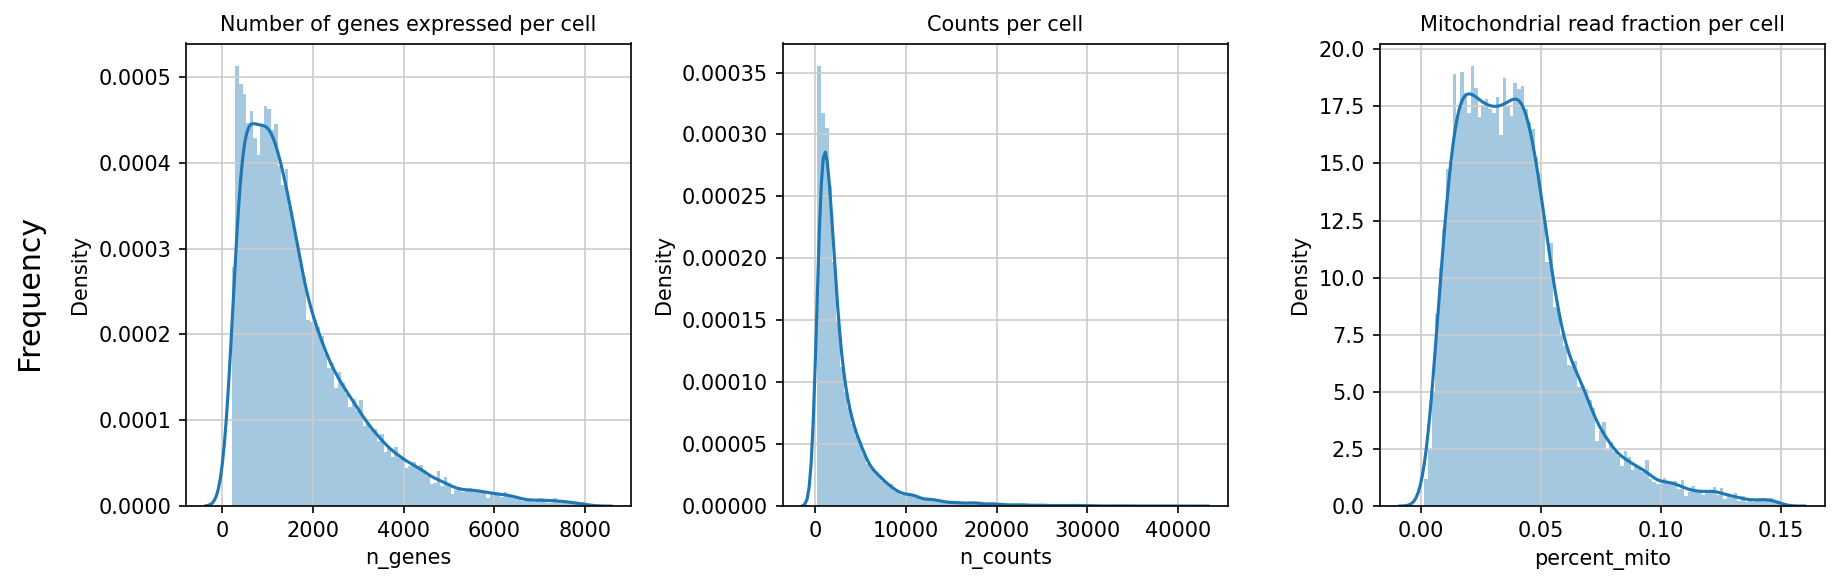

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

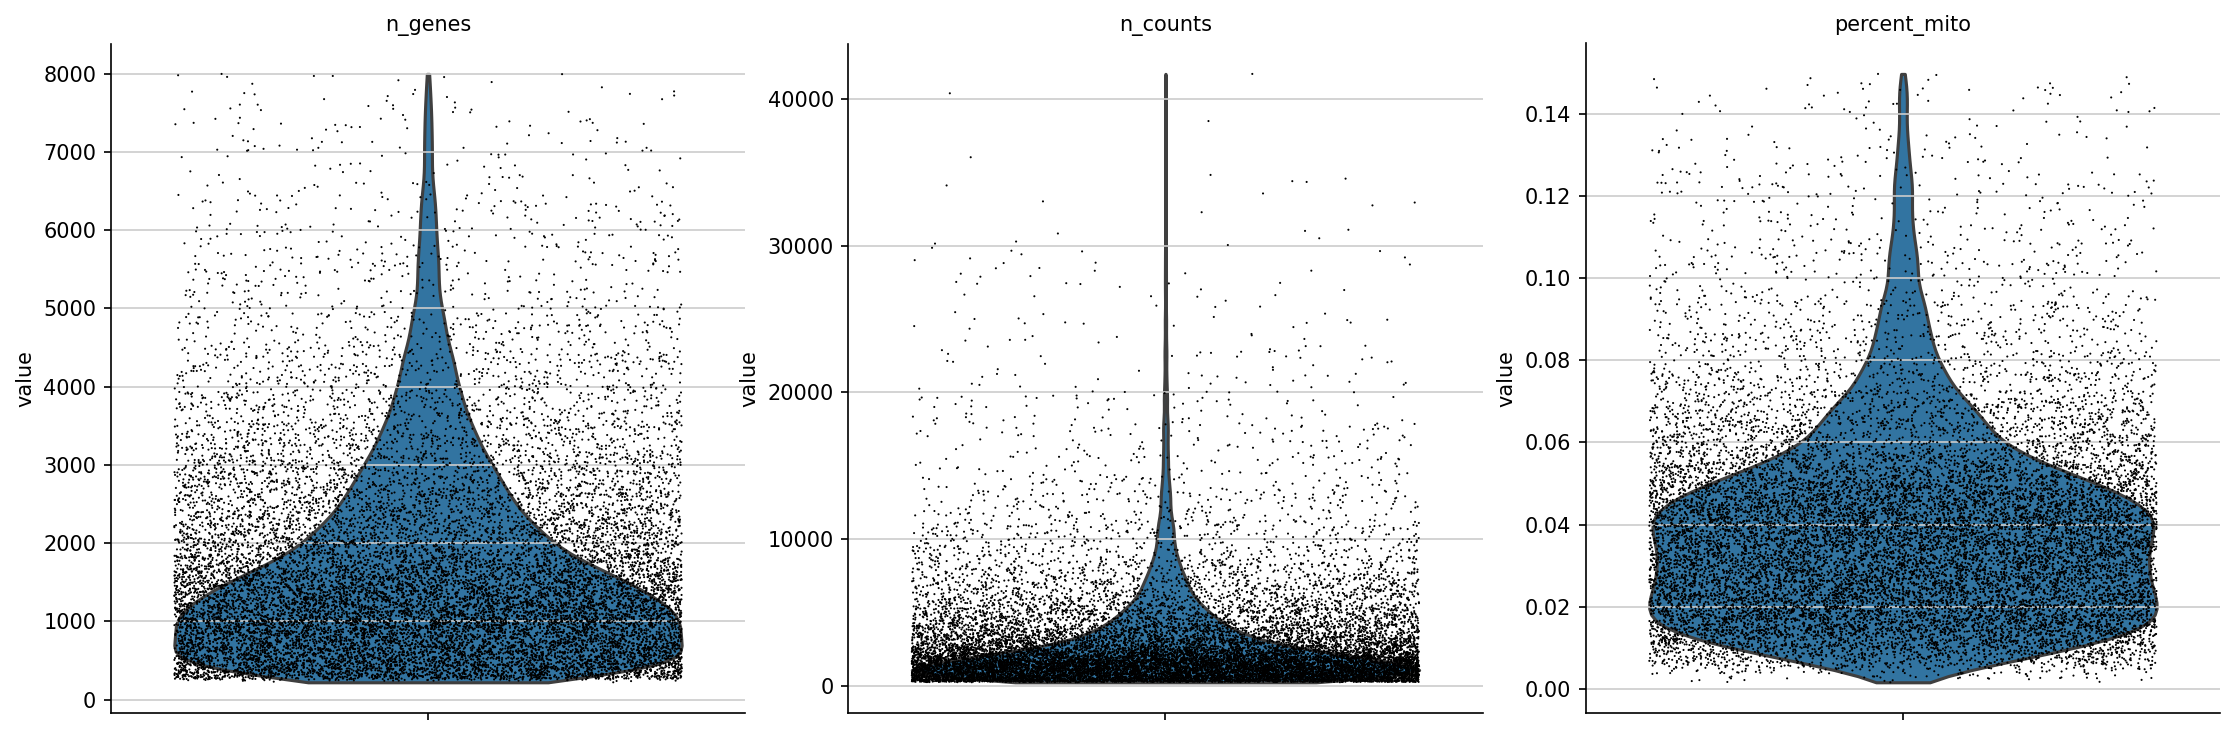

In [25]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

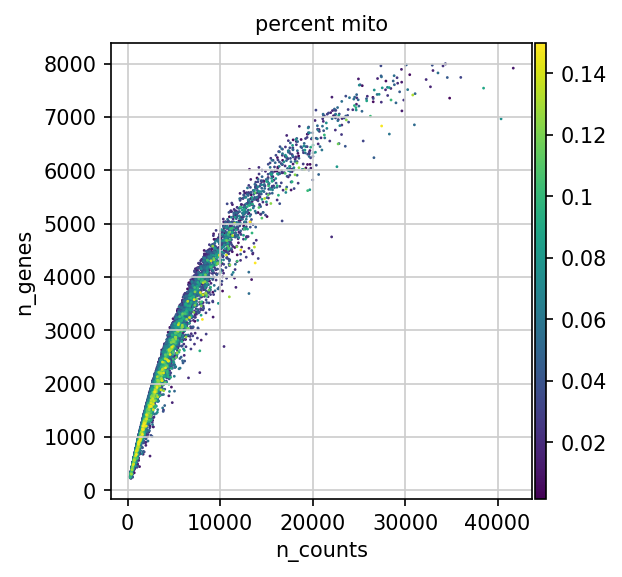

In [26]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [27]:
adata.write( f_anndata_path )

In [28]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


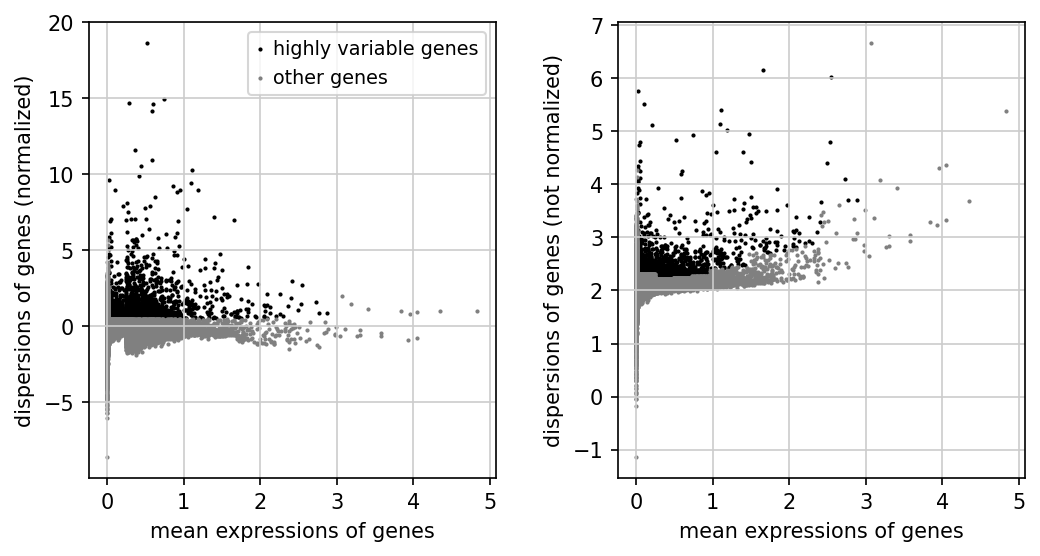

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:16)


In [29]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


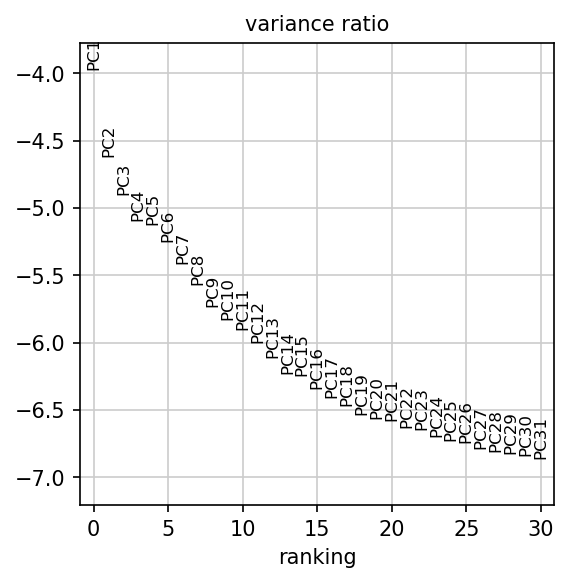

In [30]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


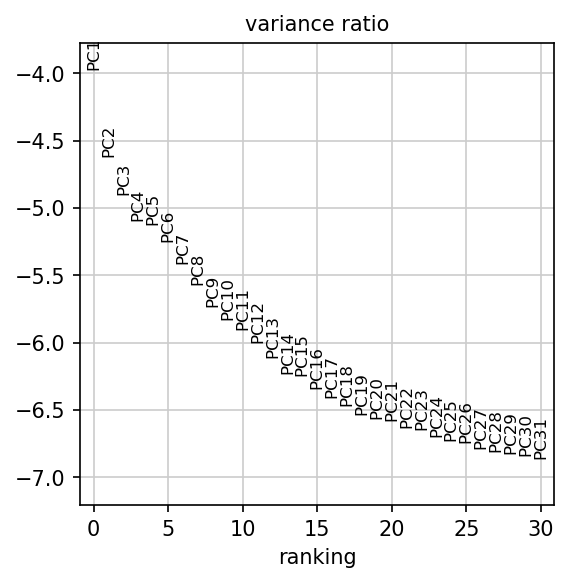

In [31]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

In [32]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


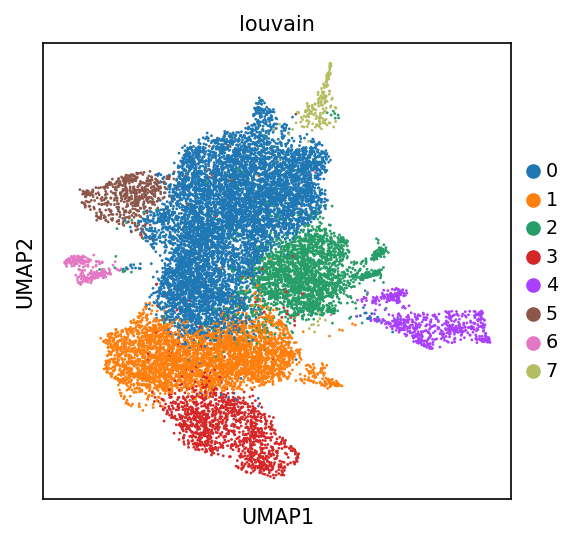

In [33]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.3)

sc.pl.umap(adata, color=['louvain'] )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


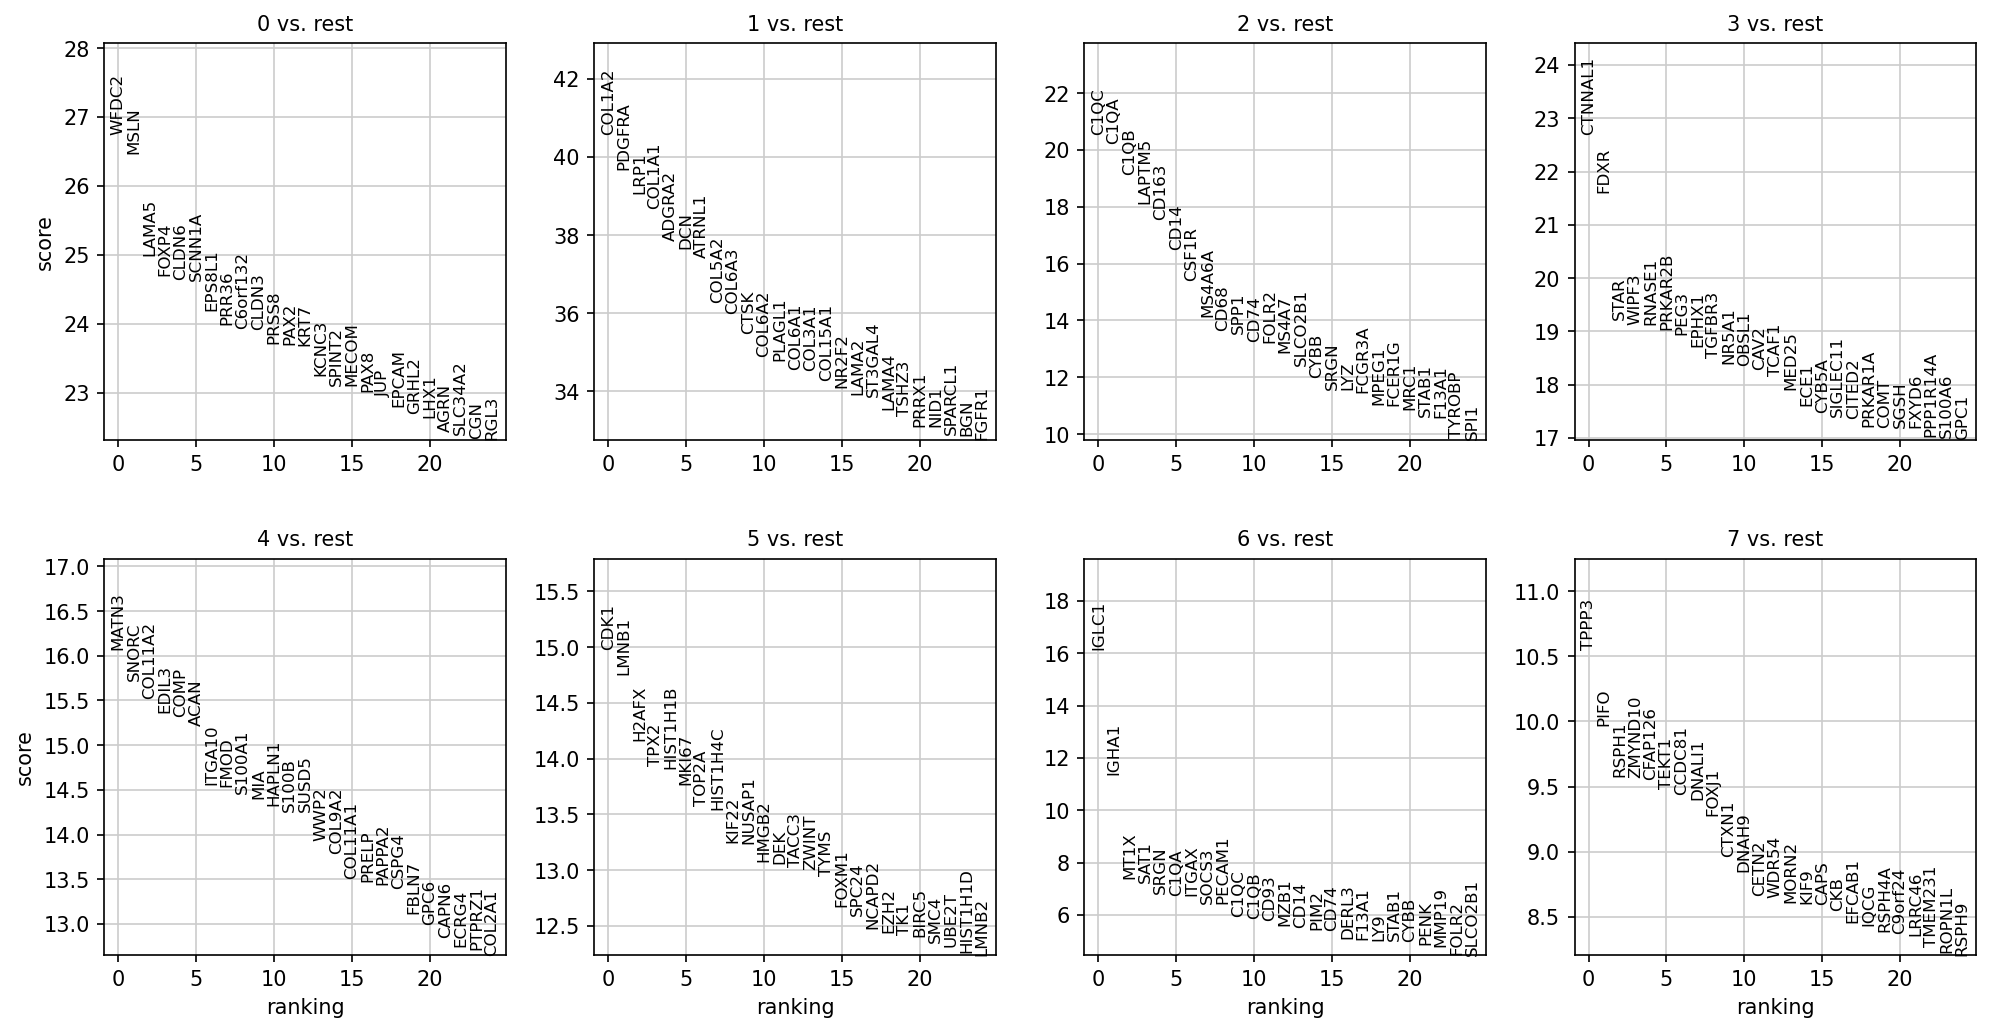

In [34]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [35]:
# transcription factors list
f_tfs = "/home/silvia/Documentos/Carcinosarcomas/databases/allTFs_hg38.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [36]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 20


2025-02-05 14:38:36,439 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-02-05 14:38:38,973 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36571 instead
  http_address["port"], self.http_server.port
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in 

In [37]:
adjacencies = pd.read_csv("adj.csv", sep=",")
adjacencies.head()

,TF,target,importance
0,FOXJ1,TPPP3,191.213360
1,FOXJ1,PIFO,144.796135
2,FOXO4,STAR,141.267376
3,EGR1,FOS,137.299128
4,FOSB,FOS,128.808677


In [38]:
import glob
# ranking databases
f_db_glob = "/home/silvia/Documentos/Carcinosarcomas/databases/old/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/home/silvia/Documentos/Carcinosarcomas/databases/old/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [39]:
!pyscenic ctx adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20


2025-02-05 16:53:44,903 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-02-05 16:53:46,748 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-02-05 16:53:49,660 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-02-05 16:53:50,529 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-02-05 16:54:09,155 - pyscenic.utils - INFO - Creating modules.

2025-02-05 16:55:33,237 - pyscenic.cli.pyscenic - IN

In [40]:
nGenesDetectedPerCellbefore = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.DataFrame(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

          0
0.01   39.0
0.05   51.0
0.10   63.0
0.50  177.0
1.00  708.0


/home/silvia/anaconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


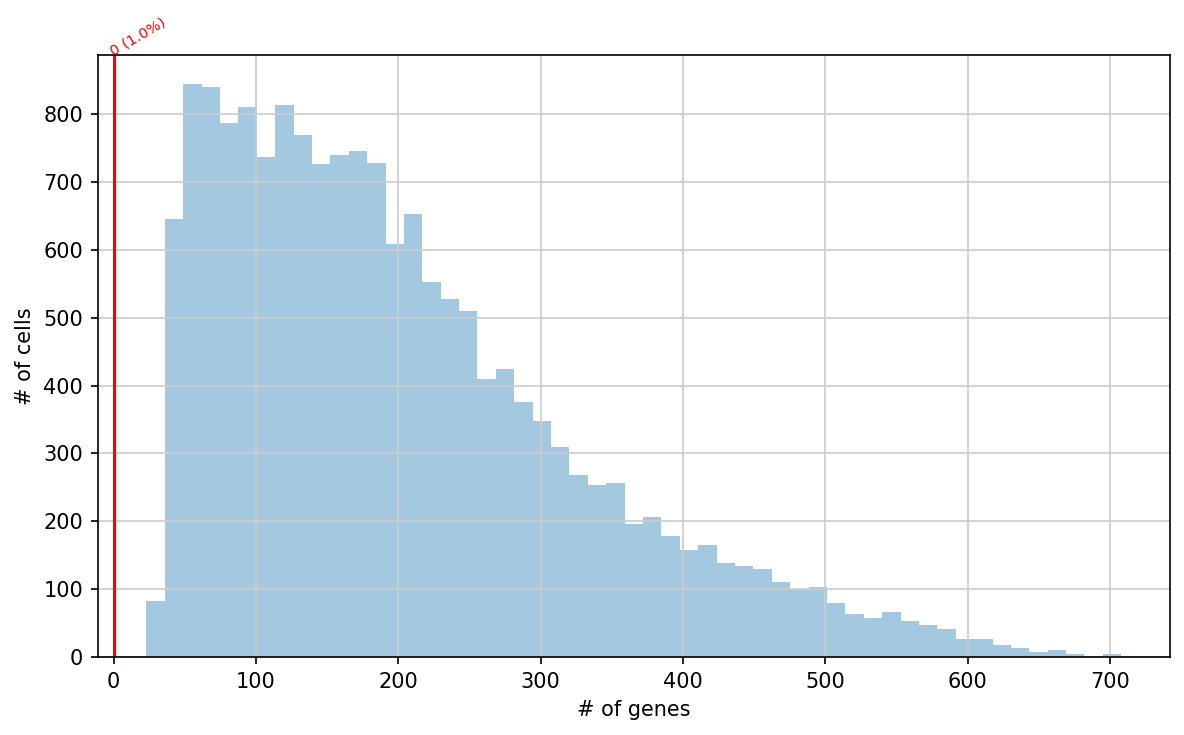

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [42]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 20


2025-02-05 17:03:29,945 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-02-05 17:03:32,461 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2025-02-05 17:04:30,477 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2025-02-05 17:04:50,120 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [43]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
#conda install -c conda-forge umap-learn

In [ ]:
#import umap

In [44]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

In [45]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [46]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

In [47]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [48]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

In [49]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [50]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [51]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file